## Read in one yaml file, pick a channel, vary one parameter, plot noises.

In [74]:
# See what yaml files are locally available.
!ls *.yaml

CHLAT_20210605.yaml    SAT_pole_20210605.yaml SPLAT_20210605.yaml


In [75]:
# Standard imports
import numpy as np
import yaml
import toml
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline  
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [10, 14]

# bolo-calc import
from bolo import Top

# Boltzmann's constant
k = 1.38e-23

# for loop gain calculation
alpha = 100

## Run
Read yaml files, run bolo_calc, store some outputs into dictionary called "data".
Print some outputs to table.

This will only work for x-parameters that are in the instrument['channel_default'] section of the yaml file, which includes:

- waist_factor: 3.0
- psat: None    
- psat_factor: 3.0
- carrier_index: 2.7   # this is beta = n-1.  
- Tc: 0.16
- Tc_fraction: None
- G: None
- Flink: None
- Yield: 0.8
- response_factor: 1.
- bolo_resistance: 0.008   # as biased in operation, ie less than R_normal
- read_frac: 0.05

### Note that the calculated optical power is not changing for any of these variations, so the Psat doesn't change unless you are changing it explicitly.

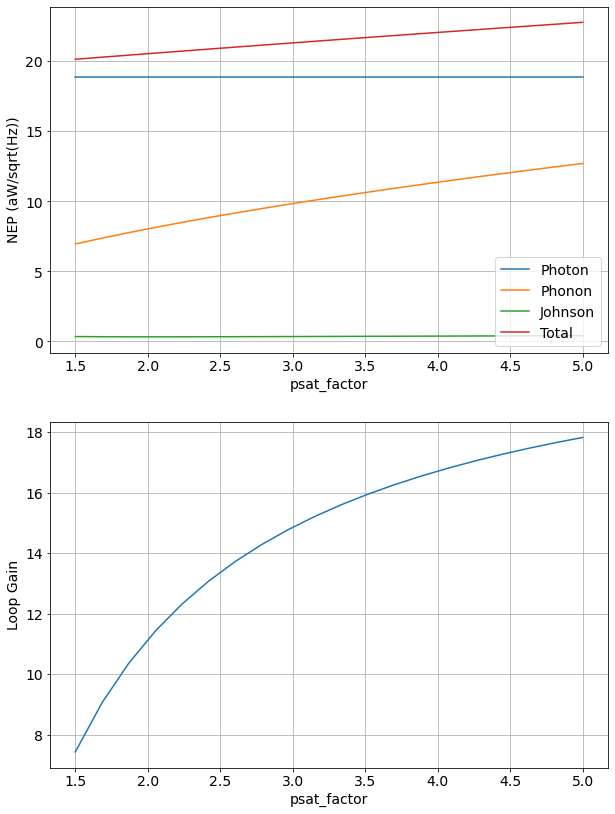

In [82]:
#### Set the parameter to vary
#xparamname = 'Tc'
#xparamvec = np.linspace(0.12,2.0,20)

#xparamname = 'carrier_index'
#xparamvec = np.linspace(1.0,3.0,20)

xparamname = 'psat_factor'
xparamvec = np.linspace(1.5,5.0,20)

# Pick the yaml file and channel
yamlfile = 'SPLAT_20210605.yaml'
channel = 'MF_1'
fullchname = 'cam_1_'+channel+'_sims'

# Set up a dictionary to store outputs
data = {'xvec':np.array([]), 
        'L0':np.array([]),
        'nep_photon':np.array([]),
        'nep_phonon':np.array([]),
        'nep_johnson':np.array([])
       }

# read in the yaml, modify dd
dd = yaml.safe_load(open(yamlfile))
version_date = str(dd['version']['date'])
version_telescope = str(dd['version']['name'])
del dd['version']

# location of atmosphere file
dd['sim_config']['config_dir'] = '../../bolo-calc/config'


# Loop over the parameter, saving outputs to dictionary of numpy vectors
for xval in xparamvec:
    # fix up dd dictionary
    data['xvec'] = np.append(data['xvec'],xval)
    
    # set param value, run bolocalc
    dd['instrument']['channel_default'][xparamname] = xval
    top = Top(**dd)
    top.run()

    # Store easy NEPs
    data['nep_photon'] = np.append(data['nep_photon'],top.instrument.tables[fullchname]['NEP_ph'][0])
    data['nep_phonon'] = np.append(data['nep_phonon'],top.instrument.tables[fullchname]['NEP_bolo'][0])

    # Calculate and store Johnson noise NEP
    T_bolo = dd['instrument']['channel_default']['Tc']
    psat_factor = dd['instrument']['channel_default']['psat_factor']
    Pelec = 1e-12*top.instrument.tables[fullchname]['P_sat'][0]*(1 - 1/psat_factor)
    Gdyn = 1e-12*top.instrument.tables[fullchname]['G'][0]
    L0 = alpha*Pelec/(Gdyn*T_bolo)
    data['L0']=np.append(data['L0'],L0)
    NEP_J_bolo = 1e18*np.sqrt(4*k*T_bolo*Pelec)/L0
    data['nep_johnson']= np.append(data['nep_johnson'],NEP_J_bolo)

# Plot NEPs on one plot.
plt.clf()
plt.subplot(2,1,1)
nep_total = np.sqrt(data['nep_photon']**2 + data['nep_phonon']**2 + data['nep_johnson']**2)
plt.plot(xparamvec,data['nep_photon'],label='Photon')
plt.plot(xparamvec,data['nep_phonon'],label='Phonon')
plt.plot(xparamvec,data['nep_johnson'],label='Johnson')
plt.plot(xparamvec,nep_total,label='Total')
plt.ylabel('NEP (aW/sqrt(Hz))')
plt.xlabel(xparamname)
plt.legend(loc='lower right')
plt.grid()

plt.subplot(2,1,2)
plt.plot(xparamvec,data['L0'])
plt.ylabel('Loop Gain')
plt.xlabel(xparamname)
plt.grid()

## Notes/keychecks below here.

In [15]:
dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][channel]

{'band_center': 25.75,
 'fractional_bandwidth': 0.33,
 'pixel_size': 16.1,
 'num_det_per_water': 96,
 'det_eff': 0.63,
 'Tc': 0.12}

In [46]:
dd['instrument']['camera_config']['elements']['cam_1'].keys()

dict_keys(['skip_optical_elements', 'chan_config'])

In [57]:
dd['instrument']['channel_default'].keys()

dict_keys(['band_response', 'num_wafer_per_optics_tube', 'num_optics_tube', 'waist_factor', 'psat', 'psat_factor', 'carrier_index', 'Tc', 'Tc_fraction', 'G', 'Flink', 'Yield', 'response_factor', 'bolo_resistance', 'read_frac'])